<a href="https://colab.research.google.com/github/JakeOh/202105_itw_bd26/blob/main/lab_ml/ml11_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learngin(앙상블 학습 방법)

* 앙상블(ensemble): 머신 러닝에서 사용되는 일련의 모델(알고리즘)들.
    * 서로 다른 모델 여러 개를 학습시키는 방법.
    * 한 가지 모델을 서로 다른 훈련 셋에서 학습시키는 방법.
* 앙상블 학습 방법: 앙상블을 사용한 머신 러닝 방법
    * 투표(voting) 방식: 여러 모델을 학습시켜서 각각의 예측값을 투표(다수결) 또는 평균값으로 예측하는 학습 방법.
    * **Bagging(Bootstrap Aggregating)**: 중복을 허용해서 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(다수결, 평균)하는 학습 방법.
    * Pasting: 중복을 허용하지 않고 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측하는 방법.
* **Random Forest**: **Bagging**을 사용한 **Decision Tree**들의 **Ensemble** 학습 방법.


# Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  # Support Vector Machine을 사용한 분류 알고리즘
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier  # Extreme Gradient Boosting
from lightgbm import LGBMClassifier

# Dataset 준비

2개의 특성(x1, x2)과, 2개의 클래스(0, 1)를 갖는 가상의 데이터 셋

In [14]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

In [6]:
X.shape, y.shape

((500, 2), (500,))

In [7]:
np.unique(y)

array([0, 1])

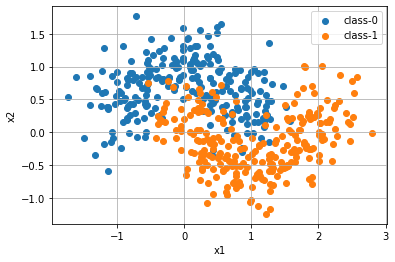

In [15]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='class-0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='class-1')

plt.legend()
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [16]:
# train/test set 분리
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [17]:
X_train.shape, X_test.shape

((400, 2), (100, 2))

# 머신 러닝 모델 비교

* 여러 개의 머신 러닝 모델들을 훈련 셋(X_train, X_test)로 훈련
    * KNN, Logistic Regression, SGD, Decision Tree, SVM
* 훈련된 각 모델에서 테스트 셋의 점수(정확도)를 계산, 평가


In [18]:
# 5개의 머신 러닝 학습기 객체 생성
knn_clf = KNeighborsClassifier(n_jobs=-1)
log_clf = LogisticRegression(random_state=42, n_jobs=-1)
sgd_clf = SGDClassifier(loss='log', n_jobs=-1, random_state=42)  # loss='log'이어야 예측 확률을 계산할 수 있음.
tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

In [19]:
knn_clf.__class__

sklearn.neighbors._classification.KNeighborsClassifier

In [20]:
knn_clf.__class__.__name__

'KNeighborsClassifier'

In [21]:
classifiers = [knn_clf, log_clf, sgd_clf, tree_clf, svm_clf]
for clf in classifiers:
    clf.fit(X_train, y_train)  # 모델 훈련
    acc = clf.score(X_test, y_test)  # 테스트 셋 평가 점수(정확도) 계산
    print(clf.__class__.__name__, 'accuracy:', acc)

KNeighborsClassifier accuracy: 0.93
LogisticRegression accuracy: 0.81
SGDClassifier accuracy: 0.81
DecisionTreeClassifier accuracy: 0.84
SVC accuracy: 0.93


# Voting Ensemble

In [22]:
# VotingEnsemble 학습기 객체 생성
vote_clf = VotingClassifier(estimators=[('knn', knn_clf),
                                        ('log', log_clf),
                                        ('sgd', sgd_clf),
                                        ('tree', tree_clf),
                                        ('svm', svm_clf)],
                            voting='soft', n_jobs=-1)
# estimators: VotingEnsemble을 만들기 위한 ML 모델 ('모델이름', 모델 객체) 튜플들의 리스트
# voting: 투표 방식
#> voting='hard': 모든 ML 모델들이 동일하게 1표씩 행사. 예측 확률을 계산할 필요가 없음.
#> voting='soft': 각 모델의 예측값에 각 모델에서 예측된 예측 확률을 가중치로 곱한 값을 사용해서 결과를 예측.
#> 일반적으로 soft voting 방식이 hard voting 방식보다 성능이 더 좋다고 알려져 있음.

In [23]:
# 모델 학습
vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('log',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto', n_jobs=-1,
                                                 penalty='l2', random_s...
                                     

In [24]:
# 모델 평가
vote_clf.score(X_test, y_test)

0.92

# Bagging(Bootrap Aggregating) Ensemble

In [25]:
# bagging ensemble 객체 생성
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                n_estimators=50,
                                max_samples=100,
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42)

BaggingClassifier의 파라미터:

* base_estimator: 기본 추정기(예측기). 머신 러닝 모델 객체.
* n_etimators: 추정기(예측기)의 개수. 기본값 10.
* max_samples: 훈련 셋의 부분 집합이 가질 수 있는 최대 샘플 개수(정수) 또는 비율(0 ~ 1.0). 기본값은 1.0.
* bootstrap: True(중복 허용 샘플링, bagging). False(중복 불허 샘플링, pasting). 기본값은 True.
* oob_score: True(OOB 샘플로 평가 점수 계산). False(OOB 샘플로 평가 점수를 계산하지 않음). 기본값은 False.
    * OOB(Out-Of-Bagging) 샘플: 중복 허용 샘플링을 하는 동안 한 번도 샘플링되지 못하고 남아 있는 훈련 셋의 샘플.
    * OOB sample은 validation set 역할을 할 수 있음.

In [26]:
# 모델 훈련
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [27]:
bagging_clf.oob_score_  # OOB(Out-of-Bagging) 샘플에서의 점수(정확도) --> 보통 테스트 셋의 점수와 비슷함.

0.905

In [28]:
bagging_clf.score(X_test, y_test)

0.91

# RandomForest

Decision Tree를 사용하는 Bagging Ensemble 학습 방법.

* DecisionTree의 파라미터와 Bagging의 파라미터들을 갖음.
* GridSearchCV, RandomizedSearchCV을 이용해서 tree와 bagging의 하이퍼파라미터들을 튜닝할 수 있음.

In [29]:
# Random Forest 분류기 객체 생성
forest_clf = RandomForestClassifier(n_estimators=50, max_samples=100, oob_score=True,
                                    n_jobs=-1, random_state=42)

In [30]:
# 모델 훈련
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
# OOB 샘플의 점수
forest_clf.oob_score_

0.9125

In [32]:
# 테스트 셋의 정확도
forest_clf.score(X_test, y_test)

0.91

# Wine datasets

red/white wine 분류

In [33]:
wine = pd.read_csv('https://bit.ly/wine-date')

In [34]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [35]:
# feature matrix, target vector
X = wine.drop(columns='class').values
y = wine['class'].values
X.shape, y.shape

((6497, 3), (6497,))

In [36]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [37]:
# Random Forest 모델 생성
forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

In [38]:
# 모델 훈련
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
# 훈련 셋에서의 정확도 - Overfitting 여부를 확인하기 위해서
forest_clf.score(X_train, y_train)

0.9978833942659227

In [40]:
# OOB 샘플 점수
forest_clf.oob_score_

0.8964787377333077

In [41]:
# 테스트 셋에서의 정확도
forest_clf.score(X_test, y_test)

0.8892307692307693

In [42]:
cross_validate(estimator=forest_clf, X=X_train, y=y_train, n_jobs=-1, return_train_score=True)

{'fit_time': array([0.8108778 , 0.80248237, 0.75484729, 0.69827962, 0.53912377]),
 'score_time': array([0.10250258, 0.1028502 , 0.10965633, 0.1024127 , 0.10227919]),
 'test_score': array([0.90480769, 0.89903846, 0.88546679, 0.89412897, 0.88546679]),
 'train_score': array([0.99807554, 0.99807554, 0.9983165 , 0.998076  , 0.9983165 ])}

# Extra Tree

* Random Forest와 비슷한 점:
    * 여러 개(기본값은 100개)의 decision tree들을 훈련
    * decision tree의 파라미터들을 튜닝할 수 있음.
* Random Forest와 다른 점:
    * Boostrap 샘플을 사용하지 않음. 여러 개의 decision tree들을 전체 훈련 셋을 사용해서 훈련.
    * 노드를 분할할 때 가장 좋은 분할을 찾는 게 아니라, 무작위 분할을 사용.
        * Random Forest는 최적의 분할을 찾기 위해서 많은 훈련 시간이 필요.
        * Extra Tree는 무작위 분할을 하기 때문에 훈련 시간이 빠름.

In [43]:
extra_tree = ExtraTreesClassifier(n_jobs=-1, random_state=42)
cv = cross_validate(estimator=extra_tree, X=X_train, y=y_train, n_jobs=-1, 
                    return_train_score=True)
cv

{'fit_time': array([0.58303213, 0.57722211, 0.58215046, 0.49875975, 0.3701005 ]),
 'score_time': array([0.1036427 , 0.10242152, 0.10238147, 0.10765338, 0.10247135]),
 'test_score': array([0.89519231, 0.90480769, 0.88450433, 0.89509143, 0.8825794 ]),
 'train_score': array([0.99807554, 0.99807554, 0.9983165 , 0.998076  , 0.9983165 ])}

In [44]:
np.mean(cv['train_score'])

0.9981720130385032

In [45]:
np.mean(cv['test_score'])
#> overfitting이 큼.

0.8924350336862368

In [46]:
# 검증 셋(validation set)에서의 평가 점수만 리턴 - overfitting 여부는 확인할 수 없음.
cross_val_score(estimator=extra_tree, X=X_train, y=y_train, n_jobs=-1)

array([0.89519231, 0.90480769, 0.88450433, 0.89509143, 0.8825794 ])

# Gradient Boosting

* 깊이(depth)가 얕은 decision tree들을 직렬로(순차적으로) 연결해서 훈련.
* 훈련시킬 때, 이전 훈련 단계에서 발생한 오차들을 그 다음 훈련에서 가중치를 주고 훈련시킴.
* 장점: 깊이가 얕은 tree를 사용하기 때문에, 과대적합이 작아지고 높은 일반화 성능을 기대할 수 있음.
* 단점: Random Forest처럼 병렬로 훈련시킬 수 없음(n_jobs 파라미터가 없음). 훈련 속도가 느림.
* Gradient Descent(경사 하강법) + Decision Tree + Ensemble 파라미터들을 튜닝할 수 있음.


In [47]:
# 모델 생성
grad_boost  = GradientBoostingClassifier(random_state=42)

In [48]:
# 교차 검증 수행
cv = cross_validate(estimator=grad_boost, X=X_train, y=y_train, n_jobs=-1, 
                    return_train_score=True)
cv

{'fit_time': array([0.51547122, 0.50985765, 0.53242207, 0.52623439, 0.33480358]),
 'score_time': array([0.00385737, 0.00435519, 0.00374722, 0.00373745, 0.00279164]),
 'test_score': array([0.87692308, 0.87692308, 0.86717998, 0.87680462, 0.85948027]),
 'train_score': array([0.88501323, 0.88645658, 0.89009139, 0.88287638, 0.88624339])}

In [49]:
np.mean(cv['train_score'])

0.886136193834053

In [50]:
np.mean(cv['test_score'])
#> overfitting이 거의 없음.

0.8714622047827053